# このページについて

ノイジーな環境における二分探索の一つである，確率的二分探索について実装を行いたいと思います．
# 確率的二分探索アルゴリズム

1. **初期化**
   既知の事前密度関数を

   $$
     f_{0}(x),\quad x\in[0,1],\quad f_{0}(x)>0,\ \int_{0}^{1}f_{0}(x)\,dx=1
   $$

   と置く．

2. **反復** $(n=0,1,\dots,N-1)$

   1. 現在の累積分布関数 (cdf) を

      $$
        F_{n}(x)=\int_{0}^{x}f_{n}(y)\,dy
      $$

      によって定義し，その中央値を計算：

      $$
        X_{n}=F_{n}^{-1}\bigl(\tfrac12\bigr).
      $$
   2. オラクルに $X_{n}$ を問い合わせ，応答 $Z_{n}\in\{+1,-1\}$ を受け取る．
      ここで，正解確率 $p\in(\tfrac12,1)$ は既知とする．
   3. 更新定数を

      $$
        \gamma_n
        =\mathbb{P}(Z_{n}=+1\mid F_{n})
        =(1-F_{n}(X_{n}))\,p+F_{n}(X_{n})\,(1-p)
      $$

      と定義し，ベイズ則で密度を更新：

      $$
      f_{n+1}(y)
      =\begin{cases}
        \displaystyle
        \frac{p\,f_{n}(y)}{\gamma_n},
        &Z_{n}=+1,\,y\ge X_{n},\\[1em]
        \displaystyle
        \frac{(1-p)\,f_{n}(y)}{\gamma_n},
        &Z_{n}=+1,\,y< X_{n},\\[1em]
        \displaystyle
        \frac{(1-p)\,f_{n}(y)}{1-\gamma_n},
        &Z_{n}=-1,\,y\ge X_{n},\\[1em]
        \displaystyle
        \frac{p\,f_{n}(y)}{1-\gamma_n},
        &Z_{n}=-1,\,y< X_{n}.
      \end{cases}
      $$

3. **出力**
   最終推定値として

   $$
     \hat X_N = F_{N}^{-1}\bigl(\tfrac12\bigr)
   $$

   を返す．


## 確率密度関数
確率密度関数$f$は，確率変数$x$の実現値がある一定の区間内で実現される確率を出すために必要な密度を表現した関数です．
### 定義

### 一様分布
定義域は，1から0の区間とし，確率変数$X$はその区間内であらゆる実数を取るものとします．

確率密度関数は，以下のように定義されます．

$$
f(x)= \begin{cases}1, & x \in[0,1], \\ 0, & \text { それ以外, }\end{cases}
$$

これは，$X$がどんな値をとってもそこにおける確率密度が一定になることを示しています．また，なぜ1であるかというと，一様分布は区間$[a,b]$について，その区間内での任意の点での密度を$\frac{1}{b-a}$としているからです．$a=0$，$b=1$とすれば，密度は1になります．

例えば確率変数が区間$[0,0.2]$の中のどれかになる確率を，確率密度関数を用いて導出してみましょう．$0<0.2$ なので，

$$
\mathbb{P}(0 \leq X \leq 0.2)=\int_{0}^{0.2} f(x) d x=\int_{0}^{0.2} 1 d x=0.2-0 = 0.2
$$

となります．では，一様分布を事前密度関数$f_0$として定義してみましょう．


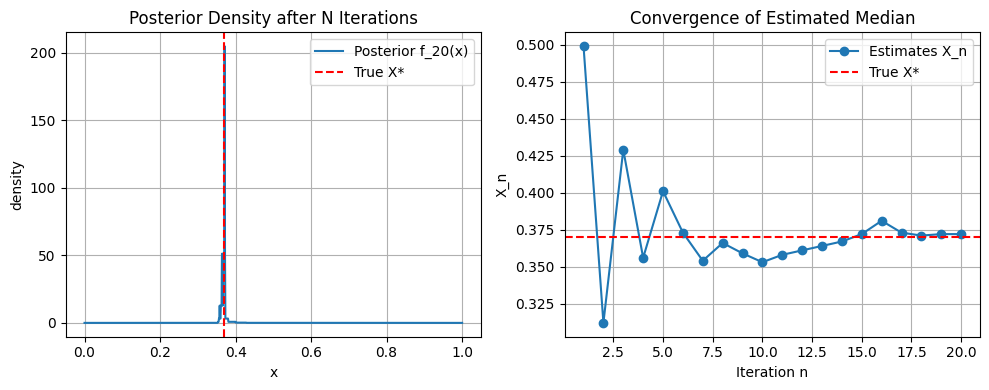

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# パラメータ設定
p = 0.8                 # オラクルの正解確率
true_X = 0.37           # 真の X*（未知だがシミュレーション用）
grid_size = 1001        # グリッドの分割数
x_grid = np.linspace(0, 1, grid_size)  # [0,1] の等間隔グリッド
dx = x_grid[1] - x_grid[0]             # グリッド間の幅

# 初期の事前密度 f0(x) を一様分布で定義
f = np.ones_like(x_grid) / (1 - 0)     # ∫0^1 f(x) dx = 1 となるように正規化

# 反復回数
N_iter = 20

# 推定された X_n の履歴を保存
medians = []

for n in range(N_iter):
    # 1) 累積分布関数 F_n の計算
    cdf = np.cumsum(f) * dx
    
    # 2) 中央値 X_n = F_n^{-1}(0.5) の計算
    idx_median = np.searchsorted(cdf, 0.5)
    X_n = x_grid[idx_median]
    medians.append(X_n)
    
    # 3) オラクルに問い合わせ（ノイズ付き回答 Z_n ∈ {+1, -1}）
    #    真の位置 true_X と比較し、その結果を確率 p で反転させる
    correct = +1 if true_X >= X_n else -1
    if np.random.rand() > p:
        correct *= -1
    Z_n = correct
    
    # 4) 更新定数 γ_n の計算
    F_at_Xn = cdf[idx_median]
    gamma_n = (1 - F_at_Xn) * p + F_at_Xn * (1 - p)
    
    # 5) ベイズ則による f を区間ごとに更新
    #    Z_n=+1: 真の X* が右側と推定 → f(y ≥ X_n) に p/γ, f(y < X_n) に (1-p)/γ を乗ずる
    #    Z_n=-1: 真の X* が左側と推定 → f(y ≥ X_n) に (1-p)/(1-γ), f(y < X_n) に p/(1-γ) を乗ずる
    if Z_n == +1:
        f[x_grid >= X_n] *= p / gamma_n
        f[x_grid <  X_n] *= (1 - p) / gamma_n
    else:
        f[x_grid >= X_n] *= (1 - p) / (1 - gamma_n)
        f[x_grid <  X_n] *= p / (1 - gamma_n)

# 結果の可視化
plt.figure(figsize=(10, 4))

# 1) 最終的な posterior f_N(x) をプロット
plt.subplot(1, 2, 1)
plt.plot(x_grid, f, label=f"Posterior f_{N_iter}(x)")
plt.axvline(true_X, color='red', linestyle='--', label="True X*")
plt.title("Posterior Density after N Iterations")
plt.xlabel("x")
plt.ylabel("density")
plt.legend()
plt.grid(True)

# 2) 反復ごとの推定値 X_n の収束をプロット
plt.subplot(1, 2, 2)
plt.plot(range(1, N_iter+1), medians, marker='o', label="Estimates X_n")
plt.axhline(true_X, color='red', linestyle='--', label="True X*")
plt.title("Convergence of Estimated Median")
plt.xlabel("Iteration n")
plt.ylabel("X_n")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
